# Hybrid Network (1D conv + LSTM) Training

Author: Luna Lyu <br>
Date: 11/10/2024

## Import Packages

In [46]:
# system
import os
import pickle
import gzip

# data manipulation
import pandas as pd
import numpy as np

# deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'/home/jianhaozheng/Downloads/luna'

## Import Dataset

In [3]:
with gzip.open('./gene_id_label_ohe (2).pkl.gz', 'rb') as f:
    data = pickle.load(f)

In [4]:
data

,ensembl_gene_id,DE,upstream_region_encoded
0,ENSG00000000457,0,"[[1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0,..."
1,ENSG00000000460,0,"[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0,..."
2,ENSG00000000938,0,"[[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [1,..."
3,ENSG00000000971,1,"[[0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0,..."
4,ENSG00000001460,0,"[[0, 0, 0, 1], [0, 0, 0, 1], [1, 0, 0, 0], [0,..."
...,...,...,...
55221,ENSG00000284520,0,"[[0, 1, 0, 0], [0, 0, 0, 1], [0, 1, 0, 0], [1,..."
55222,ENSG00000284544,0,"[[0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1,..."
55223,ENSG00000284554,0,"[[1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0,..."
55224,ENSG00000284568,0,"[[1, 0, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0,..."


## Quality Control

In [5]:
X = np.stack(data['upstream_region_encoded'].values)
Y = data['DE'].values

In [6]:
print(X.shape)
print(Y.shape)

(55223, 2000, 4)
(55223,)


In [7]:
print(type(X))
print(type(Y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Train-test Split

In [70]:
X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=123)

In [71]:
print(X_train.shape)
print(X_dev.shape)
print(Y_train.shape)
print(Y_dev.shape)
print(f"number of true labels in training split: {np.sum(Y_train)}")
print(f"number of true labels in validation split: {np.sum(Y_dev)}")

(44178, 2000, 4)
(11045, 2000, 4)
(44178,)
(11045,)
number of true labels in training split: 3342
number of true labels in validation split: 784


## Model Definition and Training

In [72]:
BATCH_SIZE = 256
EPOCH_SIZE = 5
LEARNING_RATE = 1e-3

Shuffle the dataset and apply mini-batch gradient descent with a batch size of 256:

In [73]:
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(Y_train))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = TensorDataset(torch.FloatTensor(X_dev), torch.FloatTensor(Y_dev))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [74]:
class DNAHybridClassifier(nn.Module):
    def __init__(self):
        super(DNAHybridClassifier, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(4, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2)
        )
        
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=64,
            num_layers=2,
            batch_first=True,
            dropout=0.3,
            bidirectional=True
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128, 64), 
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 2)
        )
        
    def forward(self, x):
        x = x.permute(0, 2, 1) 
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = torch.mean(x, dim=1)
        x = self.fc(x)
        return x

def train_and_evaluate(model, train_loader, val_loader, num_epochs=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3, verbose=True
    )
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()
            
            inputs = inputs
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            predicted = outputs.argmax(dim=1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = 100 * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).long()
                
                inputs = inputs
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                predicted = outputs.argmax(dim=1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * val_correct / val_total
        
        scheduler.step(epoch_val_acc)
        
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')
        print('-' * 50)
    
    # Plot results
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return history

Using device: cuda
Epoch 1/5:
Train Loss: 0.4287, Train Acc: 85.44%
Val Loss: 0.2778, Val Acc: 92.90%
--------------------------------------------------
Epoch 2/5:
Train Loss: 0.2719, Train Acc: 92.37%
Val Loss: 0.2545, Val Acc: 92.90%
--------------------------------------------------
Epoch 3/5:
Train Loss: 0.2677, Train Acc: 92.43%
Val Loss: 0.2529, Val Acc: 92.90%
--------------------------------------------------
Epoch 4/5:
Train Loss: 0.2655, Train Acc: 92.43%
Val Loss: 0.2531, Val Acc: 92.90%
--------------------------------------------------
Epoch 5/5:
Train Loss: 0.2673, Train Acc: 92.42%
Val Loss: 0.2543, Val Acc: 92.90%
--------------------------------------------------


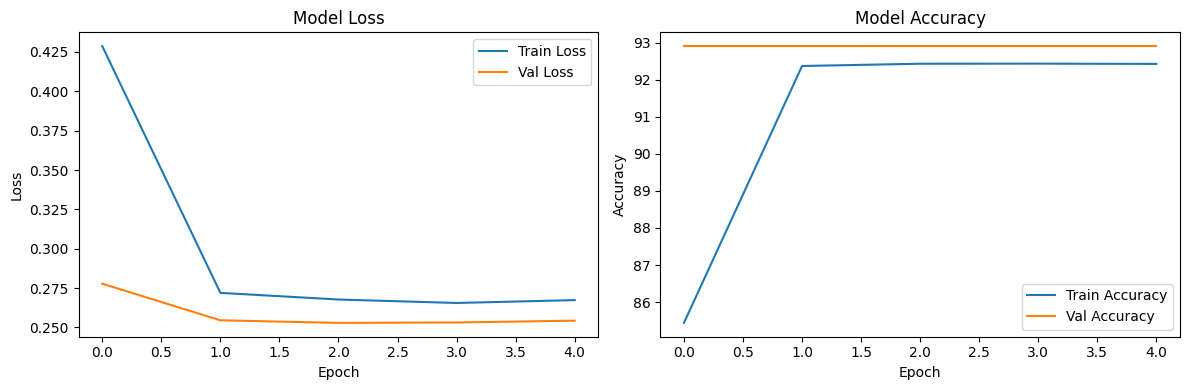

In [75]:
trained_classifier = DNAHybridClassifier()
history = train_and_evaluate(trained_classifier, train_loader, val_loader, num_epochs=EPOCH_SIZE)

In [76]:
history

{'train_loss': [0.42869821785157813,
  0.27194281757911504,
  0.2677134806882439,
  0.2655213662999214,
  0.26734334006474886],
 'train_acc': [85.44071709900855,
  92.36724161347277,
  92.42835800624745,
  92.43062157635022,
  92.42383086604192],
 'val_loss': [0.27775447138331155,
  0.25451688773252745,
  0.25286607816815376,
  0.25312521952119743,
  0.2542731267484752],
 'val_acc': [92.90176550475329,
  92.90176550475329,
  92.90176550475329,
  92.90176550475329,
  92.90176550475329]}

## GAN

In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

class DNASequenceGenerator(nn.Module):
    def __init__(self, noise_dim, seq_len=2000, num_classes=4):
        super(DNASequenceGenerator, self).__init__()
        self.conv_seq_len = 128 
        self.fc1 = nn.Linear(noise_dim, 256 * 4) 
        
        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(True),
            
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(True),
            
            nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(True)
        )
        
        # the final layer is to make the output match the target sequence length
        self.fc2 = nn.Linear(self.conv_seq_len * 8, seq_len * num_classes)
        self.seq_len = seq_len
        self.num_classes = num_classes

    def forward(self, z):
        x = self.fc1(z)
        x = x.view(x.size(0), 256, 4)
        x = self.conv_blocks(x)
        x = x.view(x.size(0), -1)
        x = self.fc2(x)
        x = x.view(x.size(0), self.seq_len, self.num_classes)
        return F.softmax(x, dim=-1)


def preprocess_data(X_train, Y_train, batch_size=32):
    """Prepare data loader with positive samples only."""
    positive_X_train = X_train[Y_train == 1]
    positive_X_train_tensor = torch.FloatTensor(positive_X_train)
    dataset = TensorDataset(positive_X_train_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

def convert_to_one_hot(generator_output):
    """Convert the output to one-hot for evaluation"""
    max_indices = torch.argmax(generator_output, dim=-1) 
    batch_size, seq_len, num_classes = generator_output.size()
    one_hot = torch.zeros_like(generator_output) 
    one_hot.scatter_(-1, max_indices.unsqueeze(-1), 1) 
    return one_hot
    
def train_gan(generator, discriminator, train_loader, trained_classifier,num_epochs=100, noise_dim=128):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    generator = generator.to(device)
    discriminator = discriminator.to(device)
    
    criterion = nn.BCELoss()
    
    optimizer_g = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    
    for epoch in range(num_epochs):
        g_losses = []
        d_losses = []
        
        for real_data, in train_loader:
            batch_size = real_data.size(0)
            real_data = real_data.to(device)
            
            # Train Discriminator
            discriminator.zero_grad()
            label_real = torch.zeros(batch_size, 2).to(device)
            label_fake = torch.zeros(batch_size, 2).to(device)
            
            label_real[:, 1] = 1
            label_fake[:, 0] = 1
            
            output_real = F.sigmoid(discriminator(real_data))
            loss_real = criterion(output_real, label_real)
            
            noise = torch.randn(batch_size, noise_dim).to(device)
            fake_data = generator(noise)
            output_fake = F.sigmoid(discriminator(fake_data.detach()))
            loss_fake = criterion(output_fake, label_fake)
            
            loss_d = (loss_real + loss_fake) / 2
            loss_d.backward()
            optimizer_d.step()
            
            generator.zero_grad()
            output_fake = F.sigmoid(discriminator(fake_data))
            loss_g = criterion(output_fake, label_real)  # Fool discriminator
            loss_g.backward()
            optimizer_g.step()
            
            g_losses.append(loss_g.item())
            d_losses.append(loss_d.item())
        
        avg_g_loss = np.mean(g_losses)
        avg_d_loss = np.mean(d_losses)
        
        if (epoch + 1) % 2 == 0:
            
            trained_classifier.eval()
            num_samples = 100
            
            with torch.no_grad():
                generated_sequences = generate_sequences(generator, num_samples=num_samples)
                labels = trained_classifier(convert_to_one_hot(generated_sequences))
                val_correct = torch.sum(labels.argmax(dim=1)).item()
            print(f'Val Acc: {100*val_correct/num_samples:.2f}%')
            print(f'Epoch [{epoch+1}/{num_epochs}] D_loss: {avg_d_loss:.4f} G_loss: {avg_g_loss:.4f}')
    
    return generator

def generate_sequences(generator, num_samples, noise_dim=128):
    """Generate DNA sequences using the trained generator."""
    device = next(generator.parameters()).device
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_samples, noise_dim).to(device)
        generated = generator(noise)
    return generated


seq_len = 2000 
noise_dim = 128
generator = DNASequenceGenerator(noise_dim=noise_dim, seq_len=seq_len)
discriminator = DNAHybridClassifier()

# Prepare new training data
train_loader = preprocess_data(X_train, Y_train, batch_size=32)

# Train the generator
trained_generator = train_gan(generator, discriminator, train_loader, trained_classifier, 
                            num_epochs=100, noise_dim=noise_dim)

Val Acc: 0.00%
Epoch [2/100] D_loss: 0.7016 G_loss: 0.7036
Val Acc: 0.00%
Epoch [4/100] D_loss: 0.6991 G_loss: 0.7014
Val Acc: 0.00%
Epoch [6/100] D_loss: 0.6987 G_loss: 0.6973
Val Acc: 0.00%
Epoch [8/100] D_loss: 0.6981 G_loss: 0.6990
Val Acc: 0.00%
Epoch [10/100] D_loss: 0.6969 G_loss: 0.6971
Val Acc: 0.00%
Epoch [12/100] D_loss: 0.6962 G_loss: 0.6968
Val Acc: 0.00%
Epoch [14/100] D_loss: 0.6971 G_loss: 0.6939
Val Acc: 0.00%
Epoch [16/100] D_loss: 0.6941 G_loss: 0.6963
Val Acc: 0.00%
Epoch [18/100] D_loss: 0.6960 G_loss: 0.6943
Val Acc: 0.00%
Epoch [20/100] D_loss: 0.6952 G_loss: 0.6942
Val Acc: 0.00%
Epoch [22/100] D_loss: 0.6944 G_loss: 0.6938
Val Acc: 0.00%
Epoch [24/100] D_loss: 0.6947 G_loss: 0.6935
Val Acc: 0.00%
Epoch [26/100] D_loss: 0.6945 G_loss: 0.6938
Val Acc: 0.00%
Epoch [28/100] D_loss: 0.6942 G_loss: 0.6935
Val Acc: 0.00%
Epoch [30/100] D_loss: 0.6942 G_loss: 0.6936
Val Acc: 0.00%
Epoch [32/100] D_loss: 0.6945 G_loss: 0.6935
Val Acc: 0.00%
Epoch [34/100] D_loss: 0.6943

In [107]:

def decode_sequences(encoded_sequences):
    """Convert \to DNA strings."""
    bases = ['A', 'T', 'G', 'C']
    decoded = []
    for seq in encoded_sequences:
        sequence = ''.join([bases[i] for i in np.argmax(seq, axis=1)])
        decoded.append(sequence)
    return decoded

generated_sequences = generate_sequences(trained_generator, num_samples=10)
decoded_sequences = decode_sequences(generated_sequences.cpu().numpy())
print(decoded_sequences[0])

CCCCTATGAACCTGTCTCGCCGAGGGTATGTGGCATCTTCAAGCCTCGGAATAGGATAACAAGAACATAGGCACGGCCAAACCCGGATGGCTGTCAAGTTAGCCCCAGCAATAAGGATAAGCGGGCGAGTCGTGATGACCAAGCCTAATGCCACCACGGGCGGCACTATGCCACCCATGCGATACTGGTCAGGTCTCGGTCTAGTGGGACTATTAAACCTCTGCGTCGGCCTCCGGAATAAGAGAACAACTAGTTGCCGCCAATTTTAGTTAATCAAAGCTACAAGAACCCATAGAGATTATGTCAAAGGCTTGTCGTAGACCAAAGTGGGAGGACCCCATGCTTGTGGTGTCATTAGAGACCAATGGCTTAATGGCTGGCTCAGTGTACTGATATACAGCGCGATGATAACCATCCCATCGATCTTCGGTCAAGCTAACCCATAAACTGAGAATGCGGGACTAATAATAGATAAGCAAGGAAGTGGAATATTTCTATTCCGGATGCCAGCCAAAATTCTCGGACTACAATGGGTGCATTCGCCAACTTAATGGGATGCTAGGACCACGAACCACCATTCGCCAACGGCTTACCCAGACACGCTAATTCAGTCGGTAAAGGGGCGGGCCGGTGCTAGCGTTGAGCCATGTCTAAAATCGACGGGTCCTCCGCTTATGGTCGGATATGAATGTAGAATGATTTCCCTCGAAATCGTCTATGCGGAGGATATAATCCACAAACCCAGGATAATATAAGTCTCAGGCCCCCAACCTTGTGGGATTACCGTTCGACTTCGCGTTGGGGAATTCGAGTAGCATGGGGCTCGCTTAGACTTCACGGCGTACCTCAAAAAGGTAGTCGAAGGCTACCGTTTGTTCATGAACACGGGGCCCATGTAAACGGACTCTAAGTCCCCCACGACTTTTCGTCAAAGCTTAGCATTACGTTTCCCTGGCGACCATCCGCTGATGGCGGACGGCGCAGGTTTCCAGGCGATAAG